In [7]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [8]:
merge_tk = th.Thicket.from_caliperreader(glob("/scratch/user/weiwu/435-group-proj/Merge_Sort/good_cali_files/*.cali"))
sample_tk = th.Thicket.from_caliperreader(glob("/scratch/user/weiwu/435-group-proj/Sample_Sort/cali/*.cali"))
bitonic_tk = th.Thicket.from_caliperreader(glob("/scratch/user/weiwu/435-group-proj/Bitonic_Sort/cali/*.cali"))
radix_tk = th.Thicket.from_caliperreader(glob("/scratch/user/weiwu/435-group-proj/Radix_Sort/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:09<00:00, 28.96it/s]


In [9]:
merge_tk.metadata_column_to_perfdata("num_procs")
merge_tk.metadata_column_to_perfdata("input_type")
merge_tk.metadata_column_to_perfdata("input_size")

merge_tk.dataframe = merge_tk.dataframe.reset_index()

In [10]:
bitonic_tk.metadata_column_to_perfdata("num_procs")
bitonic_tk.metadata_column_to_perfdata("input_size")
bitonic_tk.metadata_column_to_perfdata("input_type")

bitonic_tk.dataframe = bitonic_tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()
input_type_list = ["1%perturbed", "random", "reverse_sorted", "sorted"]
bitonic_tk.dataframe['input_type'] = [input_type_list[i % len(input_type_list)] for i in range(len(bitonic_tk.dataframe))]

bitonic_tk.dataframe = bitonic_tk.dataframe.droplevel('input_type')

bitonic_tk.dataframe = bitonic_tk.dataframe.reset_index()

In [11]:
sample_tk.metadata_column_to_perfdata("num_procs")
sample_tk.metadata_column_to_perfdata("input_type")
sample_tk.metadata_column_to_perfdata("input_size")

sample_tk.dataframe = sample_tk.dataframe.reset_index()

In [12]:
radix_tk.metadata_column_to_perfdata("num_procs")
radix_tk.metadata_column_to_perfdata("input_type")
radix_tk.metadata_column_to_perfdata("input_size")

radix_tk.dataframe = radix_tk.dataframe.reset_index()

In [13]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
input_types = ["random", "sorted", "reverse_sorted", "1%perturbed"]

# processes proportional to input sizes
processes_weak = [2, 8, 512, 1024]
input_sizes_weak = [2**16, 2**18, 2**24, 2**26]

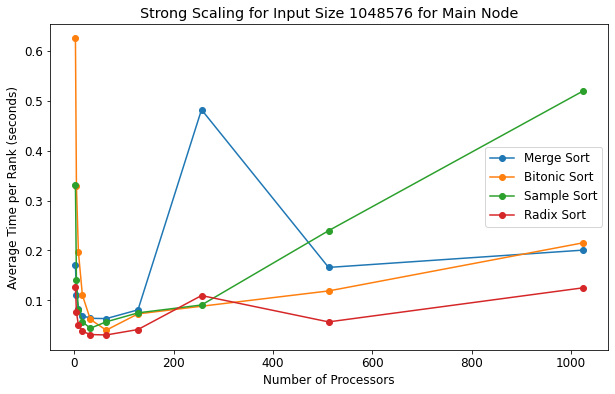

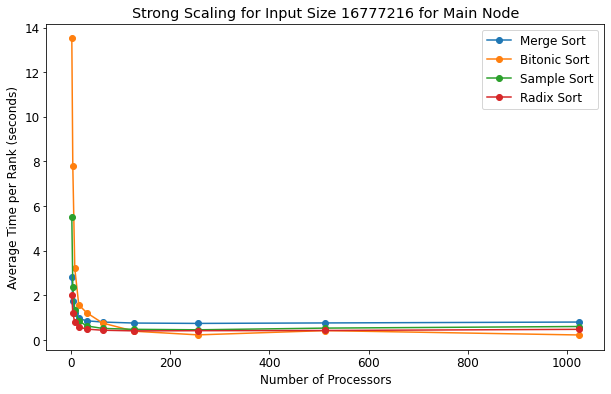

In [22]:
# Change font size for all plots
plt.rcParams.update({"font.size": 12})

# strong scaling plot for multiple algorithms for main node on random input type for 2^20 and 2^28
def plot_strong_scaling_algo_comp():
    for input_size in [2**20, 2**24]:
        fig, ax = plt.subplots(figsize=(10,6))
        # add merge sort plot
        for node in merge_tk.graph.traverse():
            if (node.frame['name'] == 'main'):
                data = merge_tk.dataframe[
                    (merge_tk.dataframe["input_type"] == 'random') &
                    (merge_tk.dataframe["input_size"] == input_size) &
                    (merge_tk.dataframe["node"] == node)
                ]
                data = data.sort_values(by="num_procs")
                ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label="Merge Sort")
        # add bitonic sort plot
        for node in bitonic_tk.graph.traverse():
            if (node.frame['name'] == 'main'):
                data = bitonic_tk.dataframe[
                    (bitonic_tk.dataframe["input_type"] == 'random') &
                    (bitonic_tk.dataframe["input_size"] == input_size) &
                    (bitonic_tk.dataframe["node"] == node)
                ]
                data = data.sort_values(by="num_procs")
                ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label="Bitonic Sort")
        # add sample sort plot
        for node in sample_tk.graph.traverse():
            if (node.frame['name'] == 'main'):
                data = sample_tk.dataframe[
                    (sample_tk.dataframe["input_type"] == 'random') &
                    (sample_tk.dataframe["input_size"] == input_size) &
                    (sample_tk.dataframe["node"] == node)
                ]
                data = data.sort_values(by="num_procs")
                ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label="Sample Sort")
        # add radix plot  
        for node in radix_tk.graph.traverse():
            if (node.frame['name'] == 'main'):

                data = radix_tk.dataframe[
                    (radix_tk.dataframe["input_type"] == 'random') &
                    (radix_tk.dataframe["input_size"] == input_size) &
                    (radix_tk.dataframe["node"] == node)
                ]
                data = data.sort_values(by="num_procs")
                ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label="Radix Sort")
        # general plot stuff
        ax.set_title(f'Strong Scaling for Input Size {input_size} for Main Node')
        ax.set_xlabel('Number of Processors')
        ax.set_ylabel('Average Time per Rank (seconds)')
        ax.legend()
        plt.show()
plot_strong_scaling_algo_comp()

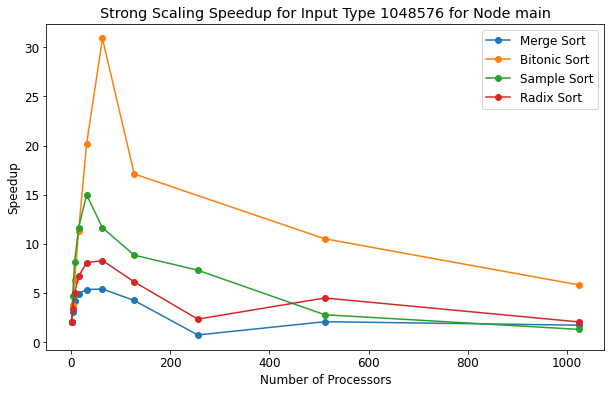

In [27]:
# strong scaling speedup plot function for main node on type random for 2^28 size
def plot_strong_scaling_speedup():
    input_size = 2**20
    fig, ax = plt.subplots(figsize=(10, 6))
    # merge sort
    for node in merge_tk.graph.traverse():
        if (node.frame['name'] == 'main'):
            # speedup calculated by execution time of 1 process / execution time of p processes
            # can just double the time for 2 process count
            t1 = merge_tk.dataframe[
                (merge_tk.dataframe["input_type"] == 'random') &
                (merge_tk.dataframe["input_size"] == input_size) &
                (merge_tk.dataframe["node"] == node) &
                (merge_tk.dataframe["num_procs"] == 2)
            ]["Avg time/rank"]*2
            data = merge_tk.dataframe[(merge_tk.dataframe["input_type"] == 'random') & (merge_tk.dataframe["input_size"] == input_size) & (merge_tk.dataframe['node'] == node)]
            data = data.sort_values(by="num_procs")
            speedups = [t1/p for p in data["Avg time/rank"]]
            ax.plot(data["num_procs"], speedups, marker='o', label='Merge Sort')
    # bitonic sort
    for node in bitonic_tk.graph.traverse():
        if (node.frame['name'] == 'main'):
            # speedup calculated by execution time of 1 process / execution time of p processes
            # can just double the time for 2 process count
            t1 = bitonic_tk.dataframe[
                (bitonic_tk.dataframe["input_type"] == 'random') &
                (bitonic_tk.dataframe["input_size"] == input_size) &
                (bitonic_tk.dataframe["node"] == node) &
                (bitonic_tk.dataframe["num_procs"] == 2)
            ]["Avg time/rank"]*2
            data = bitonic_tk.dataframe[(bitonic_tk.dataframe["input_type"] == 'random') & (bitonic_tk.dataframe["input_size"] == input_size) & (bitonic_tk.dataframe['node'] == node)]
            data = data.sort_values(by="num_procs")
            speedups = [t1/p for p in data["Avg time/rank"]]
            ax.plot(data["num_procs"], speedups, marker='o', label='Bitonic Sort')
    # sample sort
    for node in sample_tk.graph.traverse():
        if (node.frame['name'] == 'main'):
            # speedup calculated by execution time of 1 process / execution time of p processes
            # can just double the time for 2 process count
            t1 = sample_tk.dataframe[
                (sample_tk.dataframe["input_type"] == 'random') &
                (sample_tk.dataframe["input_size"] == input_size) &
                (sample_tk.dataframe["node"] == node) &
                (sample_tk.dataframe["num_procs"] == 2)
            ]["Avg time/rank"]*2
            data = sample_tk.dataframe[(sample_tk.dataframe["input_type"] == 'random') & (sample_tk.dataframe["input_size"] == input_size) & (sample_tk.dataframe['node'] == node)]
            data = data.sort_values(by="num_procs")
            speedups = [t1/p for p in data["Avg time/rank"]]
            ax.plot(data["num_procs"], speedups, marker='o', label='Sample Sort')
    # radix sort
    for node in radix_tk.graph.traverse():
        if (node.frame['name'] == 'main'):
            # speedup calculated by execution time of 1 process / execution time of p processes
            # can just double the time for 2 process count
            t1 = radix_tk.dataframe[
                (radix_tk.dataframe["input_type"] == 'random') &
                (radix_tk.dataframe["input_size"] == input_size) &
                (radix_tk.dataframe["node"] == node) &
                (radix_tk.dataframe["num_procs"] == 2)
            ]["Avg time/rank"]*2
            data = radix_tk.dataframe[(radix_tk.dataframe["input_type"] == 'random') & (radix_tk.dataframe["input_size"] == input_size) & (radix_tk.dataframe['node'] == node)]
            data = data.sort_values(by="num_procs")
            speedups = [t1/p for p in data["Avg time/rank"]]
            ax.plot(data["num_procs"], speedups, marker='o', label='Radix Sort')
    # general plot stuff
    ax.set_title(f'Strong Scaling Speedup for Input Type {input_size} for Node main')
    ax.set_xlabel('Number of Processors')
    ax.set_ylabel('Speedup')
    ax.legend()
    plt.show()
plot_strong_scaling_speedup()